In [1]:
#import tensorflow, sklearn, matplotlib, numpy and pandas
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler()

#configure pandas to show the full dataframe
pd.set_option('display.max_columns', None)

In [2]:
#import dataset city_hour.csv into a dataframe dataset
dataset_AQI = pd.read_csv('city_hour.csv')

#import dataset delhi.csv into a dataframe with date_time as index
dataset_Weather = pd.read_csv('delhi.csv')

In [3]:
#fill NaN values in all columns with interpolation
dataset_AQI['PM2.5'] = dataset_AQI['PM2.5'].interpolate()

#remove rows where all columns are NaN
dataset_AQI = dataset_AQI.dropna()

#give the number of NaN values in dataset
dataset_AQI.isnull().sum()

#give size of dataset_AQI
dataset_AQI.shape

#make a new dataframe where the City column is 'Gurugram'
dataset_AQI = dataset_AQI[dataset_AQI['City'] == 'Delhi']

#rename dataset_Weather column date_time to Datetime
dataset_Weather.rename(columns={'date_time':'Datetime'}, inplace=True)

In [4]:
#set index of dataset_Weather to Datetime
dataset_Weather.set_index('Datetime', inplace=True)
dataset_Weather.index = dataset_Weather.index.astype(str)

#set index of dataset_AQI to Datetime
dataset_AQI.set_index('Datetime', inplace=True)
dataset_AQI.index = dataset_AQI.index.astype(str)

In [5]:
#write a function that takes input in radians and returns sin + cos of that input
def sin_cos(x, mode):
    denom = 2*math.pi

    if mode == 'hour':
        return math.sin((int(x)/24)*denom) + math.cos((int(x)/24)*denom)
    elif mode == 'day':
        return math.sin((int(x)/31)*denom) + math.cos((int(x)/31)*denom)
    else:
        return math.sin((int(x)/12)*denom) + math.cos((int(x)/12)*denom)


In [6]:
#write a function to merge dataset_AQI and dataset_Weather on their indices
def merge_datasets(dataset_AQI, dataset_Weather):
    #join the two dataframes on their indices
    dataset_merged = dataset_AQI.join(dataset_Weather, how='inner')
    #dataset_AQI.merge(dataset_Weather, left_index=True, right_index=True)
    return dataset_merged

In [7]:
#make a function that takes 12 hour time and converts it to 24 hour time
def convert24(str1):

    str1 = str(str1)
      
    # Checking if last two elements of time
    # is AM and first two elements are 12
    if str1[-2:] == "AM" and str1[:2] == "12":
        return "00" + str1[2:-2]
          
    # remove the AM    
    elif str1[-2:] == "AM":
        return str1[:-2]
      
    # Checking if last two elements of time
    # is PM and first two elements are 12   
    elif str1[-2:] == "PM" and str1[:2] == "12":
        return str1[:-2]
          
    else:  
        # add 12 to hours and remove PM
        return str(int(str1[:2]) + 12) + str1[2:5]

In [8]:
#write a function that converts degrees to radians
def deg2rad(deg):
    return math.sin(deg * (math.pi/180)) + math.cos(deg * (math.pi/180))

In [9]:
#merge the two datasets
dataset_AQI_Weather = merge_datasets(dataset_Weather, dataset_AQI)

In [10]:
rem_columns = ['totalSnow_cm', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3','Benzene', 'Toluene', 'Xylene', 'AQI_Bucket', 'City', 'moonrise', 'moonset']
#drop columns from dataset_AQI_Weather that are in rem_columns
dataset_AQI_Weather.drop(rem_columns, axis=1, inplace=True)

#remove all space in columns 'sunrise', 'sunset'
dataset_AQI_Weather['sunrise'] = dataset_AQI_Weather['sunrise'].apply(lambda x: x.replace(" ",""))
dataset_AQI_Weather['sunset'] = dataset_AQI_Weather['sunset'].apply(lambda x: x.replace(" ",""))

#Convert columns 'sunrise', 'sunset' using convert24 funnction
dataset_AQI_Weather['sunrise'] = dataset_AQI_Weather['sunrise'].apply(convert24)
dataset_AQI_Weather['sunset'] = dataset_AQI_Weather['sunset'].apply(convert24)

#convert 'sunrise', 'sunset' to seconds
dataset_AQI_Weather['sunrise'] = dataset_AQI_Weather['sunrise'].apply(lambda x: (int(x[:2])*3600 + int(x[3:5])*60)/86400)
dataset_AQI_Weather['sunset'] = dataset_AQI_Weather['sunset'].apply(lambda x: (int(x[:2])*3600 + int(x[3:5])*60)/86400)

#make new column Datetime from index
dataset_AQI_Weather['Datetime'] = dataset_AQI_Weather.index

#make columns 'hour', 'day', 'month', 'year' from Datetime
dataset_AQI_Weather['hour'] = dataset_AQI_Weather['Datetime'].apply(lambda x: sin_cos(x[11:13],mode = 'hour'))
dataset_AQI_Weather['day'] = dataset_AQI_Weather['Datetime'].apply(lambda x: sin_cos(x[8:10], mode = 'day'))
dataset_AQI_Weather['month'] = dataset_AQI_Weather['Datetime'].apply(lambda x: sin_cos(x[5:7], mode = 'month'))

#apply deg2rad to columns 'winddirDegree'
dataset_AQI_Weather['winddirDegree'] = dataset_AQI_Weather['winddirDegree'].apply(deg2rad)

#drop Datetime column
dataset_AQI_Weather.drop('Datetime', axis=1, inplace=True)

#use minmax scaler on dataset_AQI_Weather
dataset_AQI_Weather = pd.DataFrame(scaler.fit_transform(dataset_AQI_Weather), columns=dataset_AQI_Weather.columns, index=dataset_AQI_Weather.index)

#make 'AQI' as the target variable
dataset_y = dataset_AQI_Weather['AQI']
dataset_x = dataset_AQI_Weather#.drop(['AQI', 'PM2.5', 'PM10'], axis=1)

#shift dataset_y by 24
dataset_y = dataset_y.shift(-24)

#drop the last 24 rows of dataset_x and dataset_y
dataset_x = dataset_x.drop(dataset_x.index[-24:])
dataset_y = dataset_y.drop(dataset_y.index[-24:])

#make dataframe dataset_test where index contains '2019'
dataset_test_y = dataset_y[dataset_y.index.str.contains('2019')]
dataset_test_x = dataset_x[dataset_x.index.str.contains('2019')]

In [11]:
dataset_x

,maxtempC,mintempC,sunHour,uvIndex,uvIndex.1,moon_illumination,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,PM2.5,PM10,AQI,hour,day,month
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 16:00:00,0.216216,0.157895,0.480392,0.0,0.4,0.72,0.982301,0.092437,0.372093,0.169811,0.153846,0.204545,0.069444,0.10,0.340426,0.0,0.783784,0.294118,0.5,0.017037,0.045455,0.242760,0.336025,0.570014,0.017037,0.917514,1.000000
2015-01-01 17:00:00,0.216216,0.157895,0.480392,0.0,0.4,0.72,0.982301,0.092437,0.348837,0.169811,0.153846,0.204545,0.097222,0.16,0.329787,0.0,0.810811,0.294118,0.5,0.603956,0.068182,0.218501,0.252180,0.561528,0.066987,0.917514,1.000000
2015-01-01 18:00:00,0.216216,0.157895,0.480392,0.0,0.3,0.72,0.982301,0.092437,0.325581,0.150943,0.134615,0.181818,0.111111,0.21,0.319149,0.0,0.810811,0.294118,0.5,0.888573,0.090909,0.251005,0.346448,0.555870,0.146447,0.917514,1.000000
2015-01-01 19:00:00,0.216216,0.157895,0.480392,0.0,0.0,0.72,0.982301,0.092437,0.348837,0.132075,0.115385,0.159091,0.125000,0.17,0.382979,0.0,0.837838,0.274510,0.5,0.960252,0.090909,0.344236,0.598145,0.596888,0.250000,0.917514,1.000000
2015-01-01 20:00:00,0.216216,0.157895,0.480392,0.0,0.0,0.72,0.982301,0.092437,0.372093,0.113208,0.096154,0.136364,0.138889,0.14,0.436170,0.0,0.837838,0.254902,0.5,0.996273,0.113636,0.391386,0.712624,0.603960,0.370590,0.917514,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.054054,0.131579,0.323529,0.0,0.0,0.26,0.982301,0.092437,0.232558,0.113208,0.096154,0.136364,0.125000,0.42,0.255319,0.0,0.837838,0.274510,0.5,0.586824,0.159091,0.288424,0.388623,0.456860,0.250000,0.853479,0.866025
2019-12-31 20:00:00,0.054054,0.131579,0.323529,0.0,0.0,0.26,0.982301,0.092437,0.232558,0.094340,0.096154,0.113636,0.125000,0.48,0.265957,0.0,0.837838,0.254902,0.5,0.612476,0.136364,0.402522,0.485005,0.456860,0.370590,0.853479,0.866025
2019-12-31 21:00:00,0.054054,0.131579,0.323529,0.0,0.0,0.26,0.982301,0.092437,0.255814,0.075472,0.076923,0.090909,0.125000,0.55,0.287234,0.0,0.864865,0.235294,0.5,0.629410,0.136364,0.540726,0.600240,0.463932,0.500000,0.853479,0.866025


In [12]:
#write a function to train a neural network on dataset_x and dataset_y
def train_model(dataset_x, dataset_y, dataset_test_x):
    #create a neural network
    model = Sequential()
    #add a layer with 100 neurons
    model.add(Dense(100, input_dim=dataset_x.shape[1], activation='relu'))
    #add a layer with 50 neurons
    model.add(Dense(50, activation='relu'))
    #add a layer with 25 neurons
    model.add(Dense(25, activation='relu'))
    #add a layer with 10 neurons
    model.add(Dense(10, activation='relu'))
    #add a layer with 1 neuron
    model.add(Dense(1, activation='linear'))
    #compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    #fit the model on the training set
    model.fit(dataset_x, dataset_y, epochs=10, batch_size=1, verbose=1)
    #make predictions on the test set
    predictions = model.predict(dataset_test_x)
    #return the model
    return model, predictions

In [13]:
model, predictions = train_model(dataset_x, dataset_y, dataset_test_x)

Epoch 1/10
24690/24690 [==============================] - 50s 2ms/step - loss: 0.0062
Epoch 2/10
24690/24690 [==============================] - 45s 2ms/step - loss: 0.0050
Epoch 3/10
24690/24690 [==============================] - 49s 2ms/step - loss: 0.0048
Epoch 4/10
24690/24690 [==============================] - 45s 2ms/step - loss: 0.0046
Epoch 5/10
24690/24690 [==============================] - 44s 2ms/step - loss: 0.0043
Epoch 6/10
24690/24690 [==============================] - 36s 1ms/step - loss: 0.0042
Epoch 7/10
24690/24690 [==============================] - 40s 2ms/step - loss: 0.0041
Epoch 8/10
24690/24690 [==============================] - 42s 2ms/step - loss: 0.0040
Epoch 9/10
24690/24690 [==============================] - 43s 2ms/step - loss: 0.0038
Epoch 10/10
24690/24690 [==============================] - 46s 2ms/step - loss: 0.0037


In [14]:
#show values in 'moonrise' that contain 'No'
dataset_x.to_csv('dataset_x.csv')

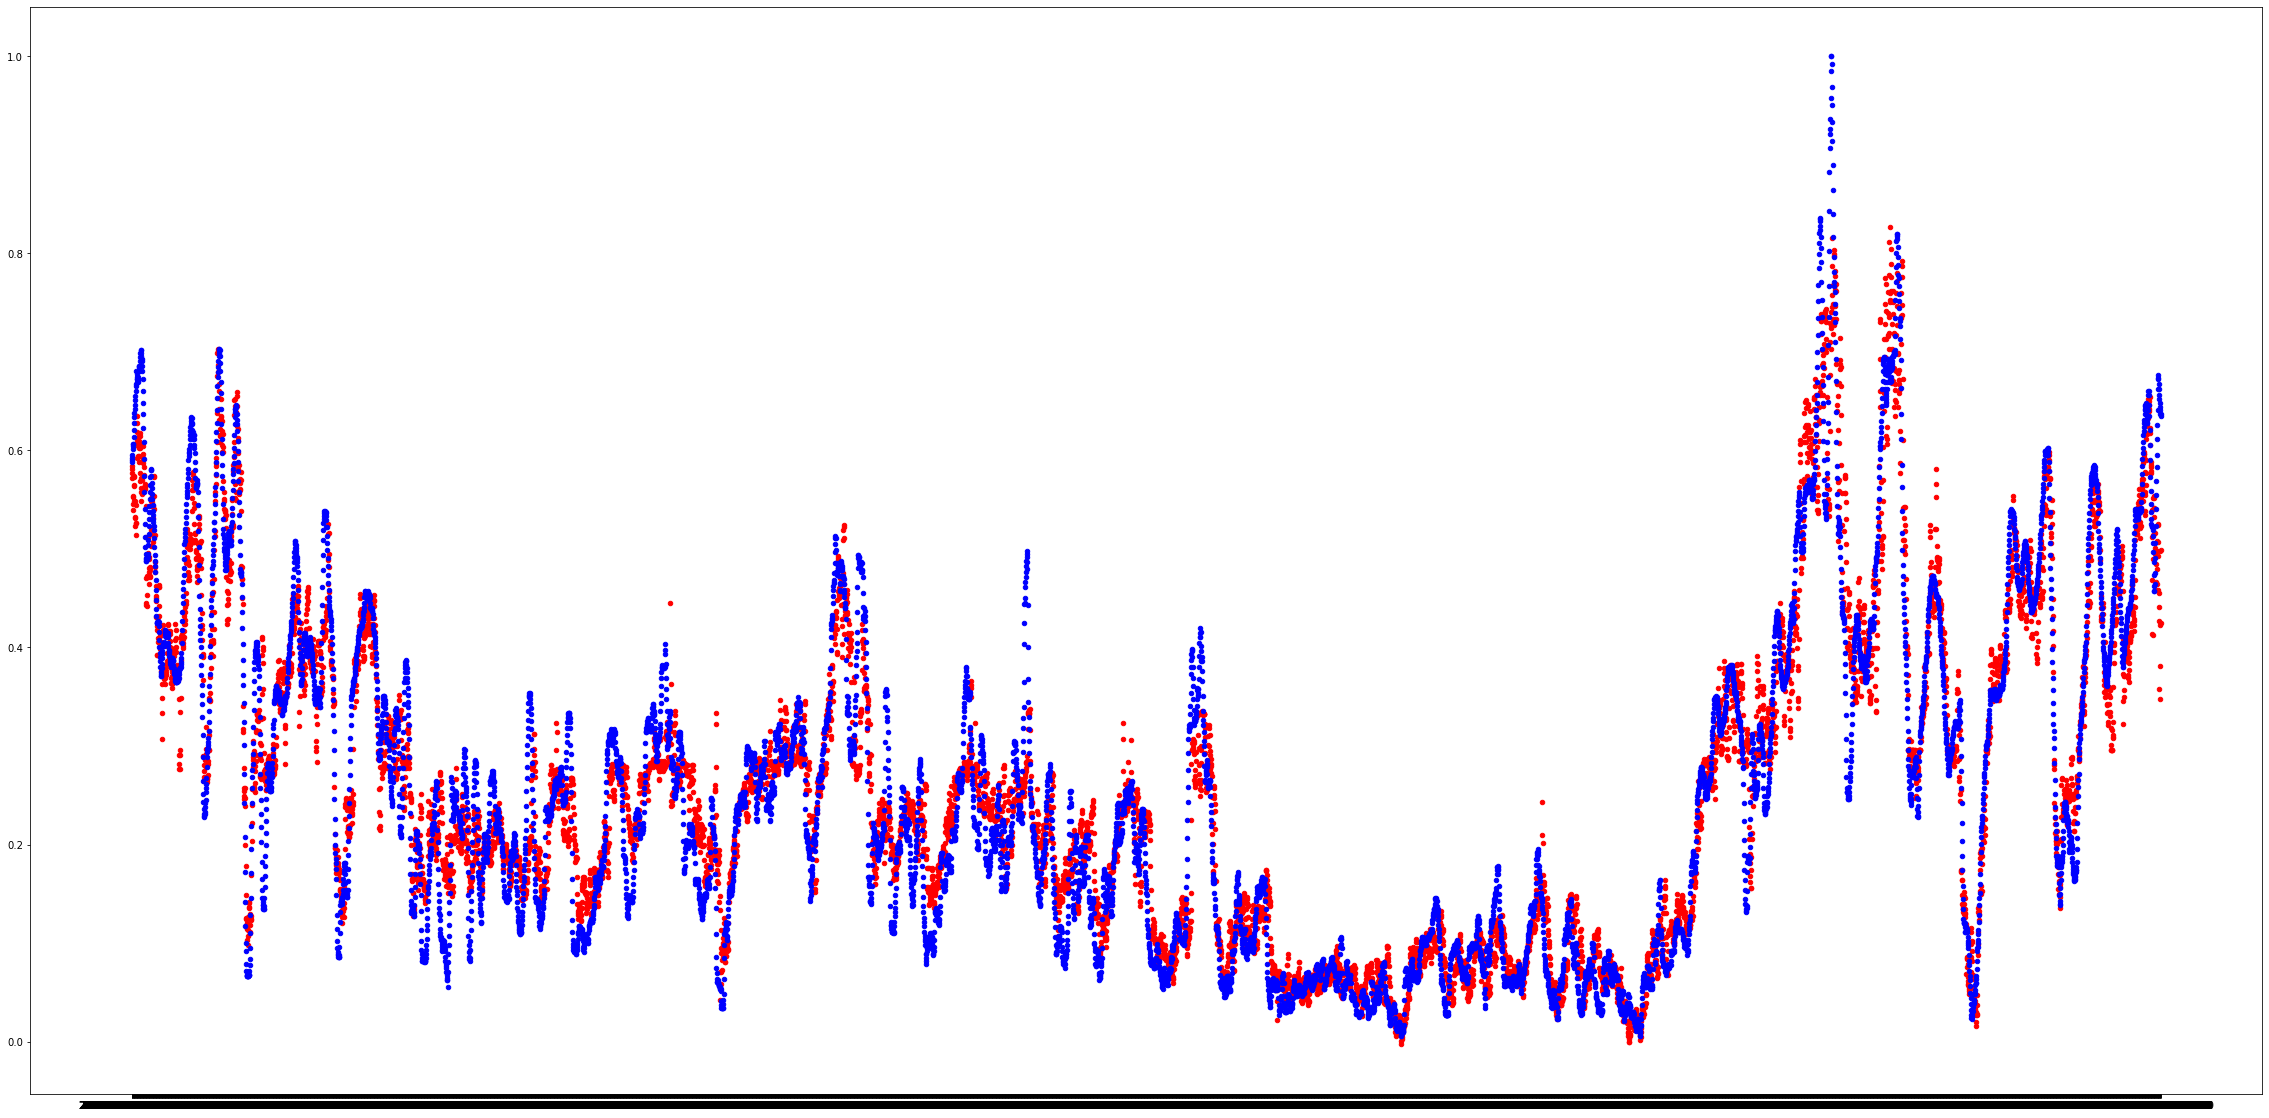

In [15]:
predictions = predictions.reshape(predictions.shape[0])

#plot prediction with x as dataset_test_x.index and y as predictions and dataset_test_y with size of 20,20
plt.figure(figsize=(40,20))
plt.scatter(dataset_test_x.index, predictions, s=20, c='red')
plt.scatter(dataset_test_x.index, dataset_test_y, s=20, c='blue')
plt.show()

In [16]:
#calculate the accuracy of the predictions against dataset_test_y
accuracy = mean_squared_error(dataset_test_y, predictions)
print(accuracy)

0.003053598685214662
